In [1]:
from models import TimeSeriesProcessor, ForALS, DfFunctions

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

dfun = DfFunctions.DfFunctions()
proc = TimeSeriesProcessor.TimeSeriesDataProcessor()
fals = ForALS.ForALS()
cl = ForALS.Clustering()

# DONE


## Data Cleaning

**raw_data** - сырые данные 

**df** - очищенные данные

**mapping_matrix_id** - таблица соответствия user_id и numeric_user_id

**mapping_matrix_trackable** - таблица соответствия trackable_name и numeric_trackable_name

In [2]:
DF_NAME="df_condition"

min_num_of_records = 20
min_trackable_name_count = 50
min_num_of_dates = 6

NUM_TOP_K = 1000

**def clean_df(df)**

1. Удаляем, где у юзеров нет age/sex/country (данных достаточно)
2. Подсчитываем количество встречаемости trackable_name
3. Выбираем записи, где количество встречаемости trackable_name > **min_trackable_name_count**
4. Удаляем ненужные колонки
5. Подсчитываем количество записей на каждого юзера и фильтруем count_of_records >= **min_num_of_records**
6. Оставляем в df_clean только отфильтрованные user_id
7. Фильтруем, что у пользователя количество дат записей >= **min_num_of_dates**
8. Созлаем матрицы соответствия для 'user_id' и 'trackable_name'
9. Удаляем столбцы 'user_id' и 'trackable_name' - у нас есть матрицы соответствия
10. Меняем порядок колонок


In [3]:

def clean_df(df):
    
    # proc.list_methods()
    df.columns = [col.lower() for col in df.columns]
    # Удаляем, где у юзеров нет age/sex/country (данных достаточно)
    df_new = df.dropna(subset=['age', 'sex','country'])
    # Подсчитываем количество встречаемости trackable_name
    df_count_trackable_name = proc.calculate_counttable_by_columnname(df,"trackable_name").sort_values(by='count', ascending=False)
    # Выбираем записи, где количество встречаемости trackable_name > min_trackable_name_count
    df_clean = proc.delete_rows_with_higher_count(df=df_new, df_count=df_count_trackable_name, min_count=min_trackable_name_count, col='trackable_name')
    # Удаляем ненужные колонки
    df_clean = proc.drop_columns_by_columnsnames(df_clean, ['count', 'trackable_type'])
    # Подсчитываем количество записей на каждого юзера и фильтруем count_of_records >= min_num_of_records
    filtered_users_with_counts = proc.filter_by_min_records(df_clean, min_num_of_records)
    # Оставляем в df_clean только отфильтрованные user_id
    df_clean = df_clean[df_clean['user_id'].isin(filtered_users_with_counts["user_id"])]
    # Фильтруем, что у пользователя количество дат записей >= min_num_of_dates
    df_clean = proc.filter_by_min_number_of_dates(df_clean, min_num_of_dates)

    # Create mapping matrices for 'user_id' and 'trackable_name'
    mapping_matrix_id, df_cleaned = proc.create_mapping_matrix(df_clean, 'user_id')
    mapping_matrix_trackable, df_cleaned = proc.create_mapping_matrix(df_clean, 'trackable_name')
   
    # Удаляем столбцы 'user_id' и 'trackable_name' - у нас есть матрицы соответствия
    df_c = proc.drop_columns_by_columnsnames(df_cleaned,['user_id','trackable_name'])

    # Меняем порядок колонок
    new_order = ['numeric_user_id', 'age', 'sex','country','checkin_date','numeric_trackable_name','trackable_value']
    df_c = df_c.reindex(columns=new_order)

    return df_c, mapping_matrix_id, mapping_matrix_trackable

raw_data = proc.load_csv(DF_NAME)

df_cleaned, mapping_matrix_id, mapping_matrix_trackable = clean_df(raw_data.copy())

print("Percent of saved rows = {percent:.2f}% or {num:d} rows".format(percent=df_cleaned.shape[0]*100/raw_data.shape[0], num=df_cleaned.shape[0]))

Percent of saved rows = 72.96% or 810981 rows


In [4]:
mapping_matrix_trackable

,trackable_name,numeric_trackable_name
0,ulcerative colitis,0
1,headache,1
2,diziness,2
3,obsessivecompulsive disorder,3
4,ovarian cysts,4
...,...,...
1494,bad balance,1494
1495,chronic allergic rhinitis,1495
1496,self control around food,1496
1497,attention span,1497


## Split to train_df, val_df, test_df

my_test: 70% : 15% : 15% (по датам)

**train** = percent*100% ; **val** = (1-percent)*100/2% ; **test** = (1-percent)*100/2%

In [5]:
df = df_cleaned.copy()

train_df, val_df, test_df = fals.split_to_train_val_test(df,percent_train=0.70)

### info about df's

In [6]:
def print_df_info(df, id='numeric_user_id', tr='numeric_trackable_name'):
    users, items, interactions = df[id].nunique(), df[tr].nunique(), df.shape[0]
    # info_str = '# users: ' + str(users) + ' # items: ' + str(items) + ' # interactions: ' + str(interactions)
    str = """users: {us:5}, items: {it:5}, interactions: {inter:7}""".format(us=users, it=items, inter=interactions)
    return str

print("raw_data:   ", print_df_info(raw_data, id='user_id', tr='trackable_name'))
print("df_cleaned: ", print_df_info(df_cleaned))
print("train_df:   ", print_df_info(train_df))
print("val_df:     ", print_df_info(val_df))
print("test_df:    ", print_df_info(test_df))

raw_data:    users: 38308, items:  8981, interactions: 1111517
df_cleaned:  users:  4892, items:  1499, interactions:  810981
train_df:    users:  4892, items:  1493, interactions:  547975
val_df:      users:  4892, items:  1490, interactions:  125800
test_df:     users:  4892, items:  1485, interactions:  137206


### test user

In [7]:
def user_print(df, test_user):
    df_user = dfun.find_row_by_user(df, test_user,  by="numeric_user_id")
    return "Dates: {dates}, Rows: {rows}".format(dates=df_user['checkin_date'].drop_duplicates().shape[0],rows=df_user.shape[0])

def user_df(df, test_user):
    df_user = dfun.find_row_by_user(df, test_user,  by="numeric_user_id")
    df_sorted = df_user.sort_values(by='checkin_date')
    return df_sorted

def info_split(train, val, test, test_user):
    print("TRAIN :",user_print(train, test_user))
    print("VALID :",user_print(val, test_user))
    print("TEST  :",user_print(test, test_user))
    pass

In [8]:
test_user_id = 14
info_split(train_df, val_df, test_df, test_user_id)

TRAIN : Dates: 20, Rows: 74
VALID : Dates: 4, Rows: 16
TEST  : Dates: 5, Rows: 20


In [9]:
# user_df(train_df,test_user_id)
# user_df(test_df,test_user_id)
# user_df(val_df,test_user_id)

## Creation of user_item_matrix

**user_item_matrix** = user_ids x top_k

In [10]:
# выбираем топ по количеству встречаемости
def top_table_by_count(df, top_k):
    popularity = proc.calculate_counttable_by_columnname(df,'numeric_trackable_name')
    top = popularity.sort_values('count', ascending=False).head(top_k)
    return top

top_k = top_table_by_count(train_df, NUM_TOP_K)
top_k_list = top_k.numeric_trackable_name.tolist()
# top_k.sort_values(by='numeric_trackable_name', ascending=False).head(10)
# top_k

In [11]:
# замена редко встречающихся диагнозов на 999999
train_df.loc[~train_df['numeric_trackable_name'].isin(top_k_list), 'numeric_trackable_name'] = 999999
# train_df.numeric_trackable_name.unique().shape[0]

In [12]:
user_item_matrix = pd.pivot_table(train_df, 
                                  index='numeric_user_id', columns='numeric_trackable_name', 
                                  values='trackable_value', 
                                  aggfunc='count', 
                                  fill_value=0
                                 )
 
user_item_matrix = user_item_matrix.astype(float) 
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head()

numeric_trackable_name,0,1,3,4,5,6,7,8,9,10,...,1483,1484,1488,1489,1490,1491,1492,1493,1495,999999
numeric_user_id,,,,,,,,,,,,,,,,,,,,,
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model ALS

In [13]:
# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
 

In [14]:
itemid_to_id, userid_to_id, id_to_itemid, id_to_userid = fals.some_ids_preparation_to_als(user_item_matrix)

In [15]:
userid = 'numeric_user_id'
itemid = 'numeric_trackable_name'
# pd.set_option('display.max_colwidth', None)

result = test_df.groupby(userid)[itemid].unique().reset_index()
result.columns=[userid, 'actual']
result.head(6)

,numeric_user_id,actual
0,0,[95]
1,1,"[8, 271, 25]"
2,2,"[136, 195, 15]"
3,3,"[0, 109, 313, 21]"
4,4,"[132, 388, 11, 118, 97, 121, 147, 61, 0]"
5,5,[0]


In [16]:
%%time 

def building_model(factors):
    model_als = AlternatingLeastSquares(factors=factors, # скрытые факторы
                                    regularization=0.001, # регуляризация, от переобучения модели
                                    iterations=30, 
                                    calculate_training_loss=True, 
                                    num_threads=4)
    
    model_als.fit(csr_matrix(user_item_matrix).tocsr(), show_progress=True)
    return model_als

model_als = building_model(200)

/Users/kaledinaoa/anaconda3/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 57 s, sys: 1.99 s, total: 59 s
Wall time: 8.28 s


In [17]:
model = model_als

# MODEL INFORMATION
print('item_factors:', model.item_factors.shape)
print('user_factors:', model.user_factors.shape)

# эмбеддинги items
item_factors=pd.DataFrame(model.item_factors)

# эмбеддинги users
user_factors=pd.DataFrame(model.user_factors)
# user_factors.head(3)

item_factors: (1001, 200)
user_factors: (4892, 200)


### umap

In [18]:
import umap

reducer = umap.UMAP(n_components=2) # to 2-dimension
umap_embeddings_users = reducer.fit_transform(user_factors)
umap_embeddings_items = reducer.fit_transform(item_factors)

### figure

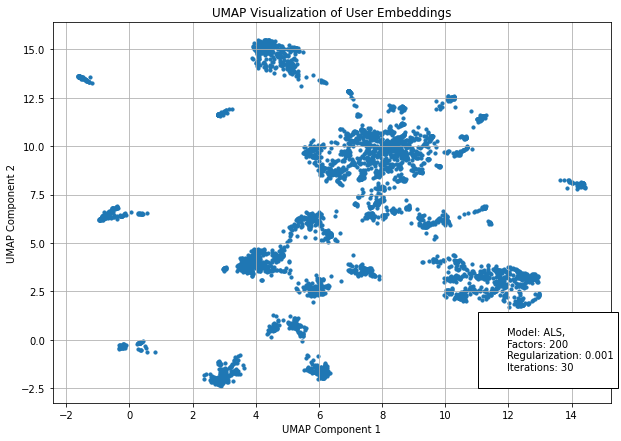

In [19]:
fals.figure_umap_embeddings(model, umap_embeddings_users, 'UMAP Visualization of User Embeddings')

## Clustering

#### KMeans

In [20]:
# kmeans_labels, kmeans_cosim_df, n_clusters = cl.print_kmeans(umap_embeddings_users, 29)
# kmeans_cosim_df

#### DBSCAN

[ True  True  True ...  True  True  True]
Estimated number of clusters: 29
Estimated number of noise points: 56
Silhouette Coefficient: 0.466


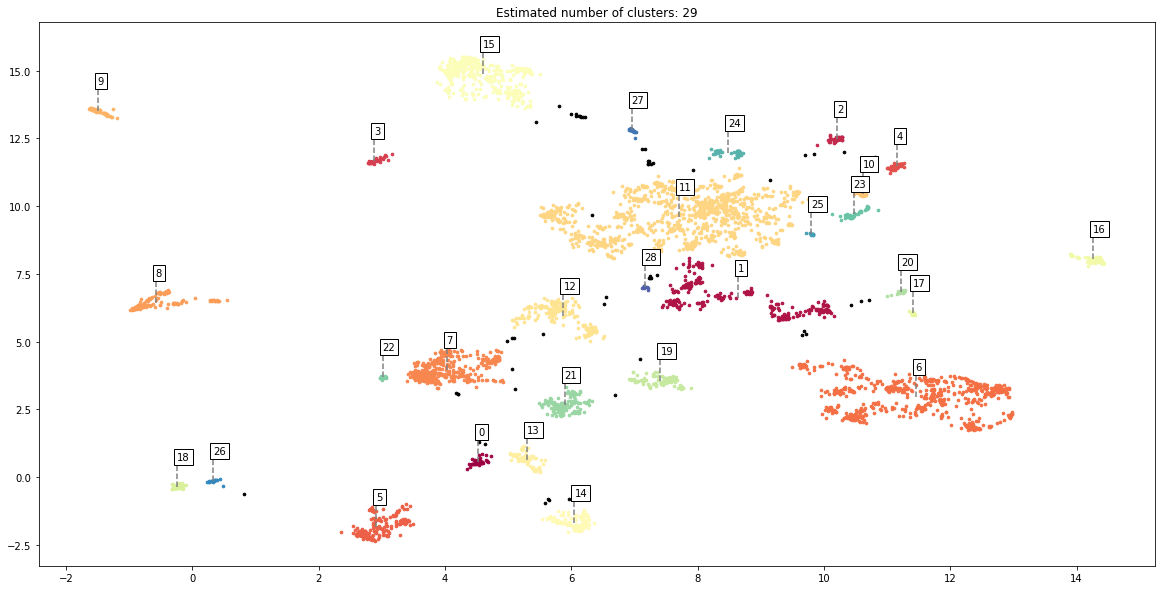

In [21]:
db_labels, db_cosim_df, n_clusters = cl.print_dbscan(umap_embeddings_users, 10)

In [22]:
db_cosim_df.head(2)

,Cluster #,Cosine Similarity
0,0,0.999085
1,1,0.993635


In [23]:
train_df_with_clusters = cl.create_df_with_cl(umap_embeddings_users, db_labels, train_df)
# train_df_with_clusters.head(2)

In [24]:
count_trname_by_cluster = cl.create_count_trname_by_cluster_dict(n_clusters, train_df_with_clusters, result)

In [25]:
count_trname_by_cluster[11].head(10)

,numeric_trackable_name,count
0,11,4267
1,32,3256
2,61,2508
3,75,2362
4,31,2068
5,50,1694
6,39,1665
7,51,1619
8,25,1386
9,16,1304


In [31]:
clusters = cl.create_usual_features_in_clusters(count_trname_by_cluster, threshold_by_item=0.1, threshold_by_main_group=0.8)

In [27]:
# clusters
# mapping_matrix_trackable.head(12)

In [32]:
# create clusters with sting dis
pd.set_option('display.max_colwidth', None)

def create_clusters_disease():
    clusters_dis={}
    mapping_dict = mapping_matrix_trackable.set_index('numeric_trackable_name')['trackable_name'].to_dict()
    for cluster_id, numeric_trackable_names in clusters.items():
        clusters_dis[cluster_id] = [mapping_dict.get(numeric_trackable_name, numeric_trackable_name) for numeric_trackable_name in numeric_trackable_names]

    df_clusters = pd.DataFrame(clusters_dis.items(), columns=['cluster_id', 'disease_ids'])
    df_clusters.set_index('cluster_id', inplace=True)
    return df_clusters

df_clusters = create_clusters_disease()
df_clusters

,disease_ids
cluster_id,
0,"[anxiety, chronic fatigue syndrome, depression]"
1,[ehlersdanlos syndrome]
2,[rheumatoid arthritis]
3,"[ulcerative colitis, hypothyroidism, acid reflux]"
4,[lupus]
5,[chronic fatigue syndrome]
6,[fibromyalgia]
7,"[depression, anxiety]"
8,[endometriosis]


# Model Prediction

### prediction